In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep, metallicity
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

DIR = "/mnt/data-storage/stellar-emulator/train"
FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"

RSTATE = 0
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

UNITS = 128
LAYERS = 7
ACTIV = "elu"
LRATE = 1e-3
BETA1 = 0.9
BETA2 = 0.999
LOSS = "mean_squared_error"
BATCH_SIZE = 65536   # 65536 corresponds to about 1000 epochs in 10 mins
MAX_EPOCHS = 100000  # about 17 hours
SHUFFLE = True
# PATIENCE = 100
# MIN_DELTA = 1e-8  # min change after PATIENCE epochs

print(f"Loading grid data from '{FILENAME}'.")
tracks = pd.read_hdf(FILENAME, "tracks")
stars = pd.read_hdf(FILENAME, "stars")
data = tracks.join(stars).dropna().reset_index()
data.head()

2023-11-27 10:11:15.825074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 10:11:15.825106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 10:11:15.825136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 10:11:15.830592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 10:11:16.453217: W tensorflow/compiler/

Using TensorFlow 2.14.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5'.


,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [2]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])
data["M_H"] = metallicity(data)

In [3]:
print("Preprocessing data.")
# Create log10 quantities
for key in [ZINI, AGE, TEFF, RAD, DNUF, MASS]:
    data[SEP.join([LOG, key])] = np.log10(data[key])

data[SEP.join([LOG, GRAV])] = log_surface_gravity(data)
data[SEP.join([LOG, LUM])] = np.log10(luminosity(data))

# Drop bad tracks
with open("../notebook/central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

data = data.drop(index=data[data.track.isin(bad)].index)

print("Calculating EEP.")
# Add EEP and drop pre-MS and post log_g cutoff
keys = [SEP.join([LOG, key]) for key in [TEFF, LUM]]
primary, secondary = calculate_eep(data, keys, alpha=0.5, boundaries=["zams", "end"])
data[PHASE] = primary
data[EEP] = secondary

data = data.drop(index=data[data.phase == -1].index)

print("Preparing train and test dataset.")
train = data.sample(frac=0.8, random_state=RSTATE)
test = data.drop(index=train.index)

Preprocessing data.
Calculating EEP.
Preparing train and test dataset.


In [4]:
# Separate features and labels
# features = [EEP, MASS, YINI, SEP.join([LOG, ZINI]), AMLT]
# labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
features = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
num_features, num_labels = len(features), len(labels)

train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [5]:
DIR = '/mnt/data-storage/stellar-emulator/tuning/20231126-134236'

In [6]:
project_name = "best_trial"
model = tf.keras.models.load_model(os.path.join(DIR, project_name, "checkpoint"))

2023-11-27 10:11:45.147780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1104 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-11-27 10:11:45.148312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18264 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [7]:
with tf.device('/gpu:1'):
    test_pred = pd.DataFrame(model(test_features), columns=test_labels.columns, index=test_labels.index)
test_pred.head()

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
7,7.729974,3.807710,-0.047598,2.169383
22,8.875592,3.808782,-0.031708,2.145162
24,8.931576,3.809216,-0.030661,2.143271
25,8.960126,3.809378,-0.029665,2.141579
30,9.068800,3.809790,-0.025871,2.135028


In [8]:
log_error = test_pred - test_labels
ln_error = log_error / np.log10(np.e)
error = 10**test_pred - 10**test_labels

In [9]:
num_samples = 10000
sample = test_labels.sample(num_samples)

Text(0, 0.5, 'log(L/Lsun)')

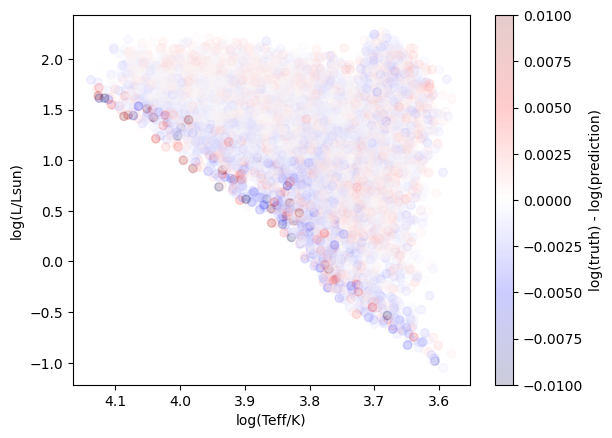

In [10]:
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

In [11]:
from matplotlib.colors import PowerNorm

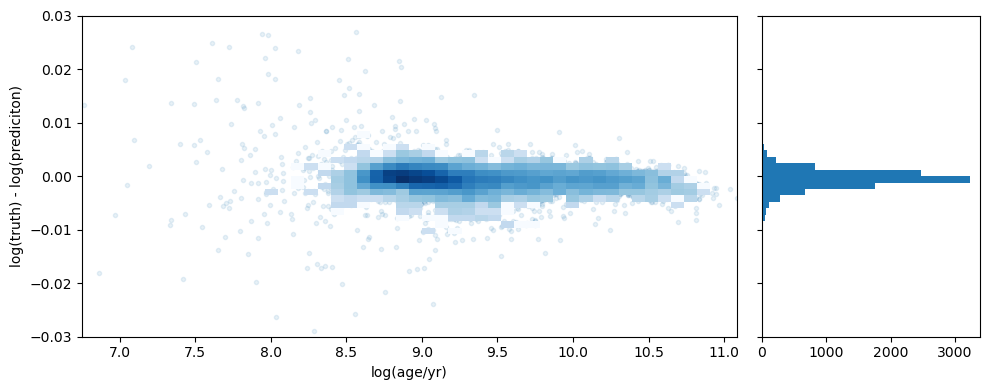

In [12]:
key = "log_star_age"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [-0.03, 0.03]
]
gamma = 1/4

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

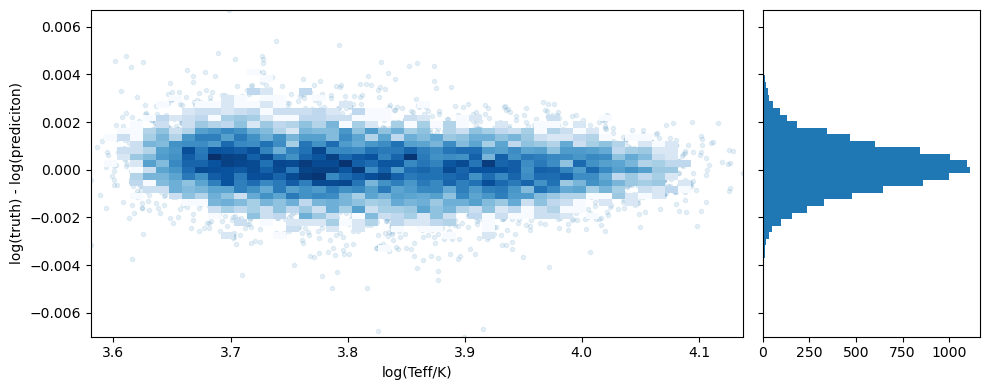

In [13]:
key = "log_Teff"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

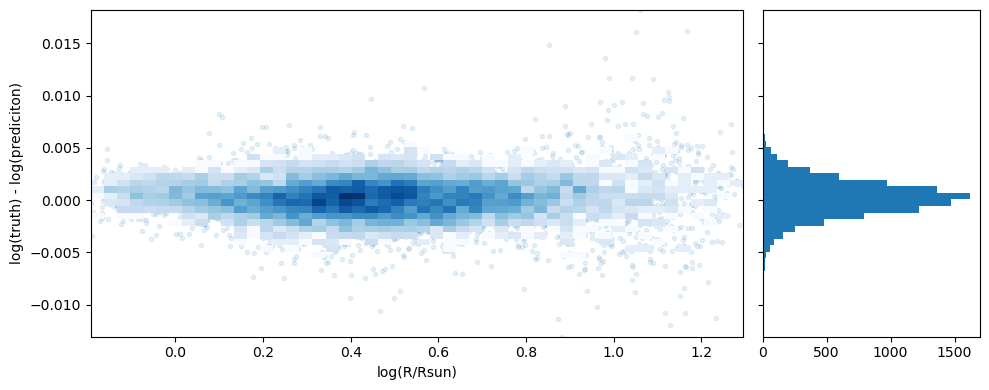

In [14]:
key = "log_radius"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))
ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

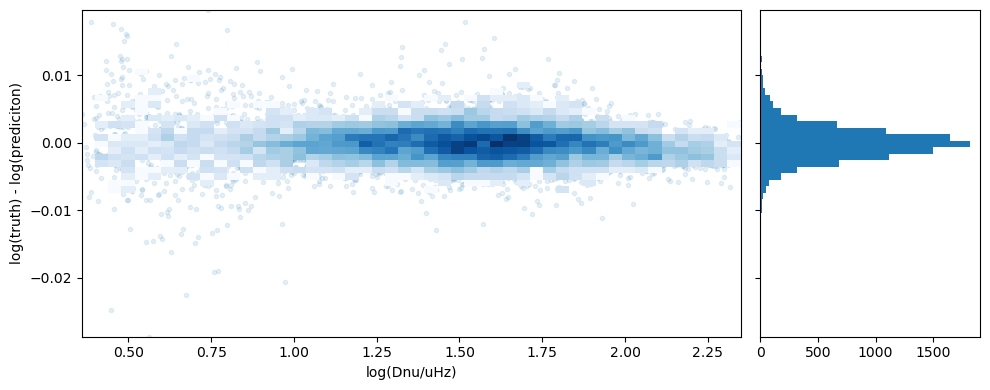

In [15]:
key = "log_Dnu_freq_o"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

In [16]:
quantiles = [.01, .16, .5, .84, .99]

In [17]:
log_error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-0.008511,-0.002627,-0.004789,-0.006972
0.16,-0.002074,-0.000912,-0.001389,-0.002388
0.50,-0.000445,0.000084,0.000250,-0.000190
0.84,0.000956,0.001081,0.001880,0.002043
0.99,0.007450,0.002876,0.005146,0.007544


In [18]:
error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-2.119263e+08,-44.302246,-0.077573,-0.991409
0.16,-1.273039e+07,-14.475098,-0.009663,-0.197525
0.50,-1.035968e+06,1.264648,0.001349,-0.009676
0.84,2.716416e+06,16.396074,0.014465,0.148747
0.99,5.651113e+07,44.105469,0.107788,0.708786


## To Do

- How propagates to parallax, luminosity etc.
- Start inference algorithm
    - 1 star
    - N stars
- In parallel train and improve emulator

In [19]:
test_pred["radius"] = 10**test_pred["log_radius"]
test_pred["Teff"] = 10**test_pred["log_Teff"]
test_pred["L"] = luminosity(test_pred)
test_pred["log_L"] = np.log10(test_pred["L"])

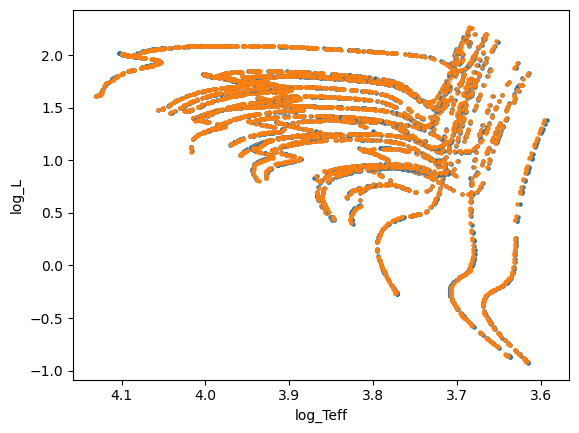

In [20]:
num_tracks = 20
random_state = 1
fig, ax = plt.subplots()
for ti in test.track.sample(num_tracks, random_state=random_state):
    mask = test.track == ti
    ax = test.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = test_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

In [25]:
eep = np.linspace(0, 1., 201)
mass = np.ones_like(eep) * 1.
mh = np.zeros_like(eep)
yi = np.ones_like(eep) * 0.28
amlt = np.ones_like(eep) * 2.0

x = np.stack([eep, mass, mh, yi, amlt], -1)
y = model(x)

In [26]:
example = pd.DataFrame(x, columns=features)
example = example.join(pd.DataFrame(y, columns=labels))
example["radius"] = 10**example["log_radius"]
example["Teff"] = 10**example["log_Teff"]
example["L"] = luminosity(example)
example["log_L"] = np.log10(example["L"])
example.head()


,EEP,star_mass,M_H,Yinit,amlt,log_star_age,log_Teff,log_radius,log_Dnu_freq_o,radius,Teff,L,log_L
0,0.000,1.0,0.0,0.28,2.0,8.071682,3.768187,-0.037867,2.185976,0.916501,5863.900391,0.894758,-0.048294
1,0.005,1.0,0.0,0.28,2.0,8.554581,3.767831,-0.035794,2.182176,0.920886,5859.102539,0.900388,-0.045570
2,0.010,1.0,0.0,0.28,2.0,8.801621,3.767533,-0.031543,2.175795,0.929944,5855.083008,0.915671,-0.038260
3,0.015,1.0,0.0,0.28,2.0,8.972363,3.768496,-0.027267,2.170443,0.939147,5868.077148,0.942202,-0.025856
4,0.020,1.0,0.0,0.28,2.0,9.085553,3.769732,-0.023672,2.165095,0.946952,5884.810547,0.968901,-0.013721


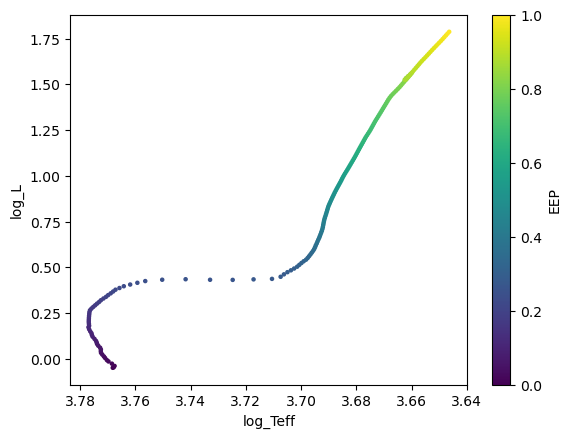

In [27]:
fig, ax = plt.subplots()

ax = example.plot(x="log_Teff", y="log_L", kind="scatter", c="EEP", marker=".", ax=ax)
ax.invert_xaxis();

<Axes: ylabel='Frequency'>

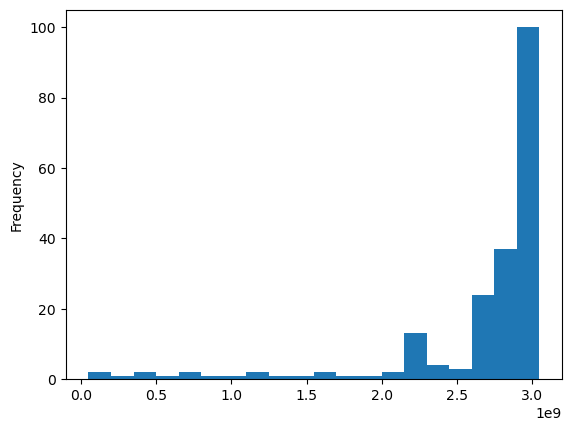

In [24]:
(10**example.log_star_age).plot(kind="hist", bins=20)